In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
np.random.seed(5)

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/wikibook/machine-learning/2.0/data/csv/basketball_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/wikibook/machine-learning/2.0/data/csv/basketball_test.csv")

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import numpy as np

In [4]:
def svc_param_selection(X, y, nfolds):
    svm_parameters = [
                        {'kernel': ['rbf'],
                         'gamma': [0.00001,0.0001, 0.001, 0.01, 0.1, 1],
                         'C': [0.01, 0.1, 1, 10, 100, 1000]
                        }]
    
    clf = GridSearchCV(SVC(), svm_parameters, cv=10)
    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_params_)
    
    return clf

In [5]:
#3점 슛과 블로킹 횟수를 학습데이터로 사용
X_train = train[['3P', 'BLK']]
#농구선수의 포지션을 예측값으로 사용 한다
y_train = train[['Pos']]
# 최적의 파라미터를 sklearn의 gridsearch를 통해 구하기 
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [6]:
X_train = train[['3P', 'BLK']]
y_train = train[['Pos']]
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [7]:
# 최적의 C와 최적의 C를 비교하기 위한 다른 C를 후보로 저장
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C'])
C_canditates.append(clf.best_params_['C'] * 100)
#  최적의 gamma와 최적의 gamma를 비교하기 위한 다른 gamma를 후보로 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)
#3점 슛과 블로킹 횟수로 학습
X = train[['3P', 'BLK']]
Y = train['Pos'].tolist()

# 포지션에 해당하는 문자열 SG와 C를 벡터화하기
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)



<ipython-input-8-a1877bb28271>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
<ipython-input-8-a1877bb28271>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
<ipython-input-8-a1877bb28271>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y

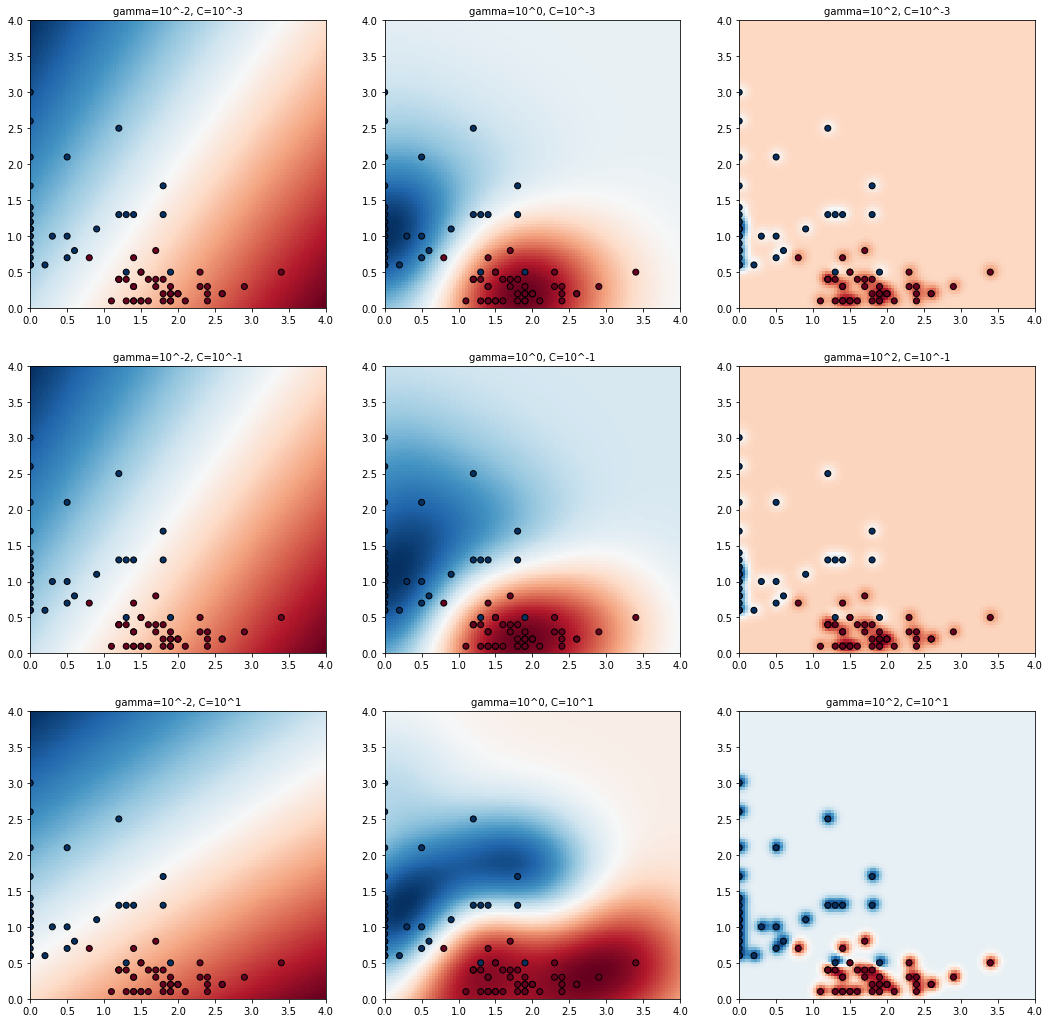

In [8]:
# 각각의 파라미터에 해당하는 SVM 모델을 만들어 classifiers에 저장

classifiers = []
for C in C_canditates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

# 18,18 사이즈의 차트를 구성

plt.figure(figsize=(18, 18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

# 각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화

for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화
    
    plt.subplot(len(C_canditates), len(gamma_candidates), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # 서포트 벡터와 결정경계선을 시각화
    
    
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')

In [9]:
# 테스트에 사용될 특징을 지정

X_test = test[['3P', 'BLK']]

# 특징으로 예측할 값 (농구선수 포지션)을 지정

y_test = test[['Pos']]

# 최적의 파라미터로 완성된 SVM에 테스트 데이터를 주입하여, 실제값과 예측값을 얻기

y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
print()
print("accuracy : "+ str(accuracy_score(y_true, y_pred)) )

              precision    recall  f1-score   support

           C       1.00      0.91      0.95        11
          SG       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20


accuracy : 0.95


In [10]:
# 실제값(ground truth)과 예측값(prediction)이 어느 정도 일치하는  직접 비교

comparison = pd.DataFrame({'prediction':y_pred, 'ground_truth':y_true.values.ravel()}) 
comparison

,prediction,ground_truth
0,C,C
1,SG,SG
2,C,C
3,SG,SG
4,C,C
5,C,C
6,C,C
7,SG,SG
8,SG,SG
9,C,C
